# Processing social media data 

In Python, we will use the simplejson library to convert the JSON data for each tweet, so let's first import it.  The 'as' keyword is used to change the name of an imported tool to something shorter and more convenient.  

In the code, you may see the symbol "#", this represents a comment and is not run by Python, but simply provides you with more information within the code itself. 

### Step 1: Loading our data

In [1]:
import json
import urllib.request

We will retrieve the data from an external site, and then read each tweet, and pull out the values we need for our analysis.  We wish to extract the "date" the tweet was published ("created_at"), The tweet id ("id_str") to act as our unique reference when storing and retrieving each tweet, and the tweet "text".  As we are interested in geolocation data, we also extract the longitude and latitude of from the tweet "coordinates" attribute, the place name ("place"), and whether the location is a town or city ("place_type").


In [9]:
temp = [] 

url = "https://raw.githubusercontent.com/BBKdatasciencetaster/DS/main/data/twitter_data_olio_UK_a.csv"

filename, headers = urllib.request.urlretrieve(url)

with open(filename, 'r') as infile:
    for line in infile:
        tweet = json.loads(line)
        timestamp = tweet['created_at']
        message_id = tweet['id_str']
        text = tweet['text']
        
        lat, lng = tweet['geo']['coordinates']
        
        place_name = tweet['place']['name']
        place_type = tweet['place']['place_type']

        temp.append([timestamp, message_id, place_name, place_type, lat, lng, text])

To recap, we now have a list of values extracted from the tweets. To explore this data we will make use of a tool for called Pandas, a Python library for data analysis and visualisation. We begin by importing the library, as follows:

### Step 2: Transforming our data

In [10]:
import pandas as pd

As we mentioned previously, Pandas uses the concept of a data frame, a datastructure used to store tabular data, such as that found in spreadsheets and databases. The first argument is our temporary list containing all the tweets we just collated from the .csv file.  We then define the column labels we will use for our data.

In [11]:
df = pd.DataFrame(temp, columns=['date', '_id', 'place_name', 'place_type', 'lat', 'lng', 'text'])
df['date'] = pd.to_datetime(df['date']) 

We can now start to explore further by looking at a summary of the data across all columns. We use the Pandas .head() function to view the first few rows of the dataset. This is also a good method for checking that our data was correctly loaded and partitioned into the columns.

In [12]:
df.head(10)

,date,_id,place_name,place_type,lat,lng,text
0,2020-09-29 20:57:35+00:00,1311047494021701632,Oadby,city,52.588300,-1.096120,"""Hovis granary wholemeal"" in #Leicester #Unite..."
1,2020-09-29 20:43:53+00:00,1311044046471585792,Oadby,city,52.588300,-1.096120,"""Celery"" in #Leicester #UnitedKingdom https://..."
2,2020-09-29 20:43:26+00:00,1311043935322611712,Hammersmith,city,51.486500,-0.226510,"""Eat 17 - small baguettes"" in #London #UnitedK..."
3,2020-09-29 20:41:30+00:00,1311043448972083203,Barking,city,51.540900,0.122000,"""Salad"" in #Dagenham #UnitedKingdom https://t...."
4,2020-09-29 20:41:06+00:00,1311043346257772544,Glasgow,city,55.872000,-4.268960,"""Humous and Chipotle Wrap"" in #Glasgow #United..."
5,2020-09-29 20:21:16+00:00,1311038353458917376,Camberwell,city,51.495500,-0.097680,"""Sandwich 🥪"" in #London #UnitedKingdom https:/..."
6,2020-09-29 19:58:56+00:00,1311032734249295873,Portsmouth,city,50.819767,-1.087977,"""Kids bedroom curtains"" in #Portsmouth #United..."
7,2020-09-29 19:58:13+00:00,1311032553516793859,Warrington,city,53.388500,-2.662780,"""4 assorted bakery items"" in #Warrington #Unit..."
8,2020-09-29 19:58:10+00:00,1311032540929708035,Warrington,city,53.388500,-2.662780,"""4 assorted bakery items"" in #Warrington #Unit..."
9,2020-09-29 19:58:10+00:00,1311032540178849792,Warrington,city,53.388500,-2.662780,"""4 assorted bakery items"" in #Warrington #Unit..."


We have captured information about the date and time of the tweet, the message id, a place name and type, latitude and longitude coordinates and the tweet text. Looking at the text of the tweet, we can see they mention various kinds of products, mainly related to food, and particularly those with a short shelf-life. Some tweets include a hashtag for the location, but this is not always the case. In addition, we can see that in some instances the name of the outlet is included, e.g. "Pret", and "Eat 17", as well as brands e.g. "Hovis". We also observe that several of the same food items are being listed from the same location. People may list more than one item of the same product, which are posted to twitter as individual tweets.



We will look at food waste on a product level over time and per region. We will see now many sandwiches are being saved from waste by region, and since many tweets about sandwiches also mention the brand, we can look at this in terms of Pret, Tesco, and Costa, some of the main outlets for sandwiches.

Before we proceed we will write three helper functions that will enable us to filter the data given a text string specifiying a keyword or product. We are using a simple approach using regular expressions, a sequence of characters that define a search pattern to match a string. Python has a built in library for regular expressions called 're', which we import.

The tweet text contains a description of the product being listed, and luckily this description is enclosed in double quotation marks making it easy to pull out only the product text and ignore all other text pertaining to the hashtags.

Our first function 'getProduct' will iterate through our data set and extract the item description using the re.findall() method given a pattern and text to match that pattern against. We then collate the latitude and longitude coordinates for the tweets matching our search string 'product', which is the only argument passed to this function.

The second function 'countProductByLocation' iterates through our data set and like the previous function, will match a text string in the tweet message that we specify.  It then constructs a new Pandas DataFrame based on the counts we obtain for the matched string (in our case a food product), which we will use as the data for plotting.

The third function 'countByHour' will take the list of hours and coordinates, count up the number of instances per hour, and convert it to a dataframe for summarising and plotting later. By defining these two functions, we can query different products to help us explore deeper into the data with not too much effort or repetition of code.


In [13]:
import re # <- import the regular expression library for string matching.

def getProduct(df, product):
    hour_list = {}
    
    for lat, lng, hour, text, place_name in zip(df.lat, df.lng, df.date.dt.hour, df.text, df.place_name):
        
        matches = re.findall(r'"(.*?)"', text)
        
        matched_text = "".join(matches)

        if product.lower() in matched_text.lower():
            hour_list.setdefault(hour, []).append([lat, lng])
            
            continue # <- We move on to the next tweet after already finding a match

    # index containing the hours extracted from the date and timestamp
    index = [str(i) +':00' for i in range(len(hour_list.keys()))]
    
    return index, hour_list

def countProductByLocation(df, product):
    place_counts = {}
    
    for lat, lng, hour, text, place_name in zip(df.lat, df.lng, df.date.dt.hour, df.text, df.place_name):
        
        matches = re.findall(r'"(.*?)"', text)
        
        matched_text = "".join(matches)

        if product.lower() in matched_text.lower():
            place_counts.setdefault(place_name, 0)
            place_counts[place_name] += 1
            
            continue # <- We move on to the next tweet after already finding a match

    places_df = pd.DataFrame.from_dict(place_counts, orient='index')
    
    places_df.reset_index(inplace=True)
    places_df.columns=['place_name', 'count']
    return places_df
            

def countByHour(hour_list):
    temp = []
    for hour in sorted(hour_list.keys()):
        number_of_products = len(hour_list[hour])
        
        temp.append([hour, number_of_products])

    product_df = pd.DataFrame(temp, columns=['hour', 'count']).set_index('hour')
    
    return product_df

### Step 3: Exploring our data

With our helper functions in place, we can now start to search for items mentioned in the tweet text using a very simple approach.  Let's start with a search for the keywords 'pastries', and 'sandwich' to demonstrate, later we will ask you to amend this list with your own set of keywords:

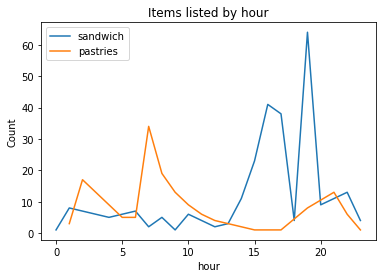

In [14]:
# Product search
products = ['sandwich', 'pastries']

main_plot = None

for product in products:
    
    index, hour_list = getProduct(df, product)

    sandwich_df = countByHour(hour_list)
    if main_plot == None:
        main_plot = sandwich_df.plot(label=product)
    else:
        sandwich_df.plot(ax=main_plot, label=product)

        
main_plot.legend(products)
main_plot.set_title('Items listed by hour')
main_plot.set_ylabel('Count')
main_plot

Now let's try that again, but this time search for brands or sandwich outlets.

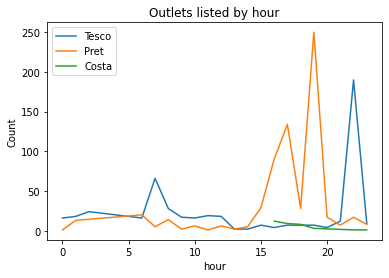

In [15]:
# Outlet search
brands = ['Tesco', 'Pret', 'Costa']

main_plot = None

for brand in brands:
    
    index, hour_list = getProduct(df, brand)

    sandwich_df = countByHour(hour_list)
    if main_plot == None:
        main_plot = sandwich_df.plot(label=brand)
    else:
        sandwich_df.plot(ax=main_plot, label=brand)

main_plot.legend(brands)
main_plot.set_title('Outlets listed by hour')
main_plot.set_ylabel('Count')
main_plot

After plotting the tweets that mention an outlet, we see that these items are generally listed in the latter part of the afternoon and late evening.

## Task

Amend the list of products stored in the "products" variable, where we currently have ['sandwich', 'pastries'], and run the above cells from <b>Step 3 Exploring our Data</b> again. If you are stuck, look over the table of data again and the text column to see if you can identify any keywords worth exploring.  You can increase the size of the sample in the table with by amending df.head(10) to df.head(20) to expand the table view to the first twenty rows of data.

You will see from this simple example analysis we can already explore a number of questions about food waste using relatively little data. Depending on your data it may be necessary to employ more sophisticated Natural Language Processing tools, but in our case the tweet text was short and formatted in a standard way, which made it straight forward to extract the product text.

## Troubleshooting

If you get an error when running the code after making changes, please refresh the page to retrieve a fresh copy of the notebook.  

If you think the issues are related to a bug outside of your control, then please flag this in the comments section for this activity.